### The German Traffic Sign Benchmark

Student Name 1: Daniel Minguez Camacho

Student Name 2: Javier de la Rua Martinez

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
# !wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip

In [1]:
import numpy as np
import cv2

# Change height and size

IMG_HEIGHT = 500
SIGN_SIZE = (128, 128)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

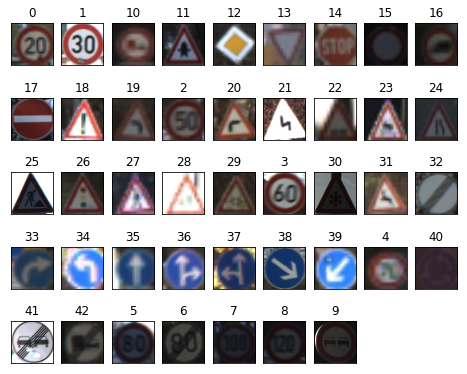

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

# Data preparation

In [4]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 128.0
va_signs /= 128.0
te_signs /= 128.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


# Callback for test evaluation

In [5]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard, EarlyStopping,ModelCheckpoint, Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.t_loss = []
        self.t_acc = []

    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_loss'] = loss
        logs['test_acc'] = acc
        print('\nT_loss: {}, T_acc: {}\n'.format(loss, acc))
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [6]:
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import GlobalAveragePooling2D,Lambda,ZeroPadding2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam

model = Sequential()
model.add(Lambda(lambda x: x, input_shape=(128, 128, 3)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(43, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 32)        0         
_________________________________________________________________
conv

# Without Data Augmentation

In [8]:
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
             TensorBoard(log_dir='logs/{}'.format(time())),
             TestCallback((te_signs, te_labels))]

# EarlyStopping(monitor='val_loss', patience=4),

In [9]:
data = model.fit(tr_signs, tr_labels, batch_size=16, epochs=75, verbose=2, validation_data=(va_signs, va_labels), callbacks=callbacks)

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 252 samples
Epoch 1/75
 - 5s - loss: 3.5501 - acc: 0.1450 - val_loss: 3.7035 - val_acc: 0.1706

T_loss: 3.566173482139355, T_acc: 0.16897506925207756

Epoch 2/75
 - 2s - loss: 2.9907 - acc: 0.2600 - val_loss: 3.2742 - val_acc: 0.2460

T_loss: 3.1206816140964753, T_acc: 0.26038781163434904

Epoch 3/75
 - 2s - loss: 2.6855 - acc: 0.3217 - val_loss: 3.2875 - val_acc: 0.2460

T_loss: 3.232571731313774, T_acc: 0.2576177285731334

Epoch 4/75
 - 2s - loss: 2.2704 - acc: 0.4150 - val_loss: 5.0935 - val_acc: 0.1706

T_loss: 5.023178288150692, T_acc: 0.19113573409266088

Epoch 5/75
 - 2s - loss: 2.0350 - acc: 0.4583 - val_loss: 3.0874 - val_acc: 0.2976

T_loss: 2.7769908759732655, T_acc: 0.3684210526522177

Epoch 6/75
 - 2s - loss: 1.6511 - acc: 0.5533 - val_loss: 2.9388 - val_acc: 0.3730

T_loss: 2.46542768267053, T_acc: 0.40166204988213455

Epoch 7/75
 - 2s - loss: 1.5031 - acc: 0.6117 - val_loss: 3.2093 - val_ac


T_loss: 0.1947661535788606, T_acc: 0.9418282551778651

Epoch 58/75
 - 2s - loss: 0.0379 - acc: 0.9900 - val_loss: 0.4351 - val_acc: 0.8889

T_loss: 0.19495252795372975, T_acc: 0.9445983382803581

Epoch 59/75
 - 2s - loss: 0.0379 - acc: 0.9900 - val_loss: 0.4287 - val_acc: 0.8889

T_loss: 0.19317251343765088, T_acc: 0.9445983382803581

Epoch 60/75
 - 3s - loss: 0.0380 - acc: 0.9900 - val_loss: 0.4295 - val_acc: 0.8889

T_loss: 0.19271810759385208, T_acc: 0.9418282551778651

Epoch 61/75
 - 2s - loss: 0.0379 - acc: 0.9900 - val_loss: 0.4268 - val_acc: 0.8929

T_loss: 0.19090711666977966, T_acc: 0.9501385044853443

Epoch 62/75
 - 2s - loss: 0.0380 - acc: 0.9900 - val_loss: 0.4325 - val_acc: 0.8929

T_loss: 0.1918125425431867, T_acc: 0.9445983382803581

Epoch 63/75
 - 2s - loss: 0.0379 - acc: 0.9900 - val_loss: 0.4270 - val_acc: 0.8929

T_loss: 0.1868698997758432, T_acc: 0.9473684213828513

Epoch 64/75
 - 2s - loss: 0.0379 - acc: 0.9900 - val_loss: 0.4268 - val_acc: 0.8929

T_loss: 0.18722

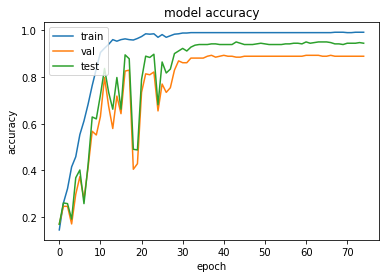

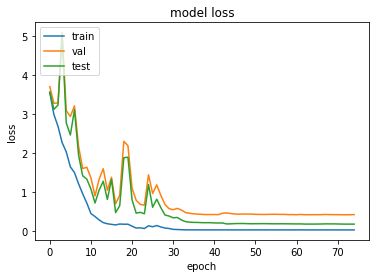

In [10]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.plot(data.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.plot(data.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.show()

# Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


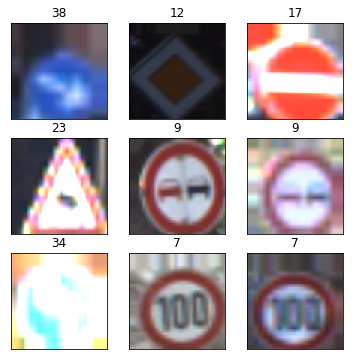

In [8]:
from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(zca_whitening=True,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
# ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# datagen = ImageDataGenerator(zca_whitening=True)
# datagen.fit(tr_signs, augment=True)
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen = ImageDataGenerator(width_shift_range=0.05, height_shift_range=0.15, zoom_range=0.15, fill_mode='nearest')
datagen.fit(tr_signs)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

In [9]:
callbacks = [ModelCheckpoint(filepath='best_model_2.h5', monitor='val_loss', save_best_only=True),
             TensorBoard(log_dir='logs/{}'.format(time())),
             TestCallback((te_signs, te_labels))]

In [10]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = model.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=150, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=callbacks)

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
 - 4s - loss: 3.5161 - acc: 0.1639 - val_loss: 3.3017 - val_acc: 0.2183

T_loss: 3.1895303310119543, T_acc: 0.22160664822008472

Epoch 2/150
 - 2s - loss: 3.1374 - acc: 0.2347 - val_loss: 3.4769 - val_acc: 0.1984

T_loss: 3.641590018021433, T_acc: 0.20221606650263318

Epoch 3/150
 - 2s - loss: 2.9422 - acc: 0.2583 - val_loss: 3.3883 - val_acc: 0.2460

T_loss: 3.553431127870512, T_acc: 0.17728531858019553

Epoch 4/150
 - 2s - loss: 2.7095 - acc: 0.2940 - val_loss: 2.7360 - val_acc: 0.3056

T_loss: 2.7960109869198786, T_acc: 0.27977839335180055

Epoch 5/150
 - 2s - loss: 2.4522 - acc: 0.3616 - val_loss: 2.5591 - val_acc: 0.3294

T_loss: 2.57162743790328, T_acc: 0.3102493074998631

Epoch 6/150
 - 2s - loss: 2.2571 - acc: 0.4003 - val_loss: 2.6671 - val_acc: 0.3333

T_loss: 2.5127934801941763, T_acc: 0.37950138506219

Epoch 7/150
 - 2s - loss: 2.0227 - acc: 0.4527 - val_loss: 2.6980 - val_acc: 0.3333

T_loss: 2.528212382852866, T_


T_loss: 0.5875397677071537, T_acc: 0.8670360112454423

Epoch 58/150
 - 3s - loss: 0.0646 - acc: 0.9865 - val_loss: 1.1459 - val_acc: 0.7817

T_loss: 0.8183487919559109, T_acc: 0.8199445986681698

Epoch 59/150
 - 3s - loss: 0.1310 - acc: 0.9730 - val_loss: 1.6355 - val_acc: 0.6270

T_loss: 1.7743299139503628, T_acc: 0.5817174520188751

Epoch 60/150
 - 3s - loss: 0.1937 - acc: 0.9425 - val_loss: 1.7289 - val_acc: 0.6468

T_loss: 1.6910484788160245, T_acc: 0.6343490308011338

Epoch 61/150
 - 3s - loss: 0.2705 - acc: 0.9257 - val_loss: 7.4490 - val_acc: 0.1508

T_loss: 8.235738763518611, T_acc: 0.11080332412036172

Epoch 62/150
 - 3s - loss: 0.2271 - acc: 0.9375 - val_loss: 0.8749 - val_acc: 0.8175

T_loss: 1.0120462872645202, T_acc: 0.7839335181706499

Epoch 63/150
 - 3s - loss: 0.1502 - acc: 0.9713 - val_loss: 1.3300 - val_acc: 0.6667

T_loss: 1.451886200178363, T_acc: 0.634349030553469

Epoch 64/150
 - 3s - loss: 0.1074 - acc: 0.9679 - val_loss: 5.1839 - val_acc: 0.2460

T_loss: 5.2224


T_loss: 0.767378355657625, T_acc: 0.8254847652033755

Epoch 116/150
 - 3s - loss: 0.0378 - acc: 0.9899 - val_loss: 0.5366 - val_acc: 0.8849

T_loss: 0.4066678027408275, T_acc: 0.9141274239878245

Epoch 117/150
 - 2s - loss: 0.0105 - acc: 0.9966 - val_loss: 0.3607 - val_acc: 0.9167

T_loss: 0.3258645386742093, T_acc: 0.9252077563977968

Epoch 118/150
 - 2s - loss: 0.0075 - acc: 0.9983 - val_loss: 0.3219 - val_acc: 0.9325

T_loss: 0.32063505886550836, T_acc: 0.9196675903579205

Epoch 119/150
 - 2s - loss: 0.0055 - acc: 0.9983 - val_loss: 0.2972 - val_acc: 0.9365

T_loss: 0.29882749497188754, T_acc: 0.9362880888077691

Epoch 120/150
 - 2s - loss: 0.0136 - acc: 0.9966 - val_loss: 0.3316 - val_acc: 0.9325

T_loss: 0.49520868411767516, T_acc: 0.8864265929628937

Epoch 121/150
 - 2s - loss: 0.0128 - acc: 0.9950 - val_loss: 0.3346 - val_acc: 0.9325

T_loss: 0.3250322157202335, T_acc: 0.9390581719102622

Epoch 122/150
 - 2s - loss: 0.0134 - acc: 0.9949 - val_loss: 0.3478 - val_acc: 0.9405

T_l

In [14]:
from keras.models import load_model
model2 = load_model('best_model_2.h5')

start = time()
loss, acc = model2.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 0.6109945774078369 seconds
Test loss: 0.27436745561558723 - Accuracy: 0.9529085874227275


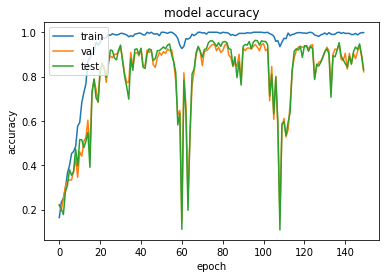

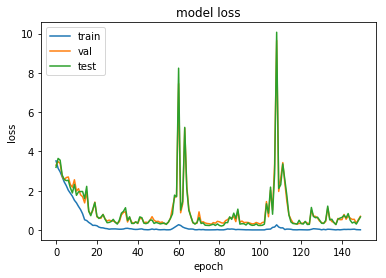

In [11]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.plot(data.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.plot(data.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.show()